<a href="https://colab.research.google.com/github/demi-echo/CodeClauseInternship_DemandForecastingForRetailStore/blob/main/Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/stat

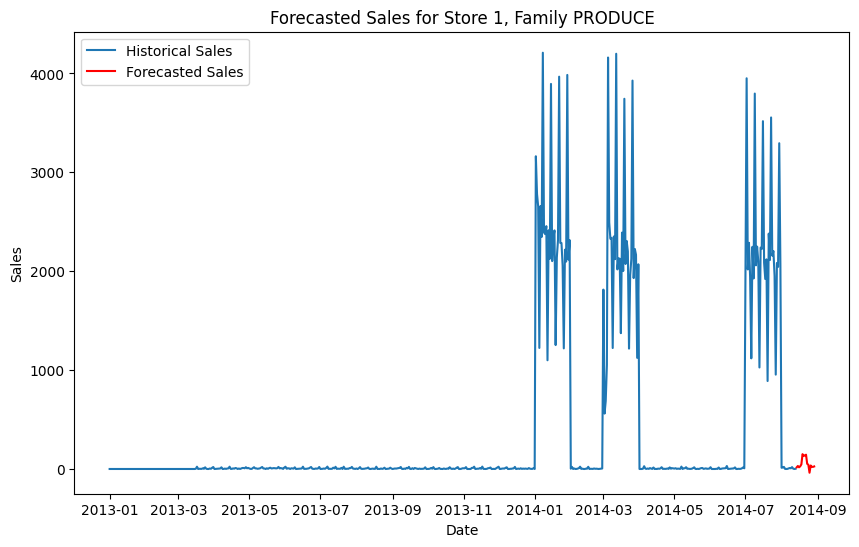

Forecasted Sales Dates: 2014-08-14 00:00:00 to 2014-08-29 00:00:00
Test Set Dates: 2017-08-16 00:00:00 to 2017-08-31 00:00:00
No common dates found between forecasted sales and test set.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load the datasets
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

# Convert 'date' columns to datetime with dayfirst=True, using errors='coerce' to handle parsing errors
train['date'] = pd.to_datetime(train['date'], dayfirst=True, errors='coerce')
test['date'] = pd.to_datetime(test['date'], dayfirst=True, errors='coerce')

# Check for and handle any NaT values
if train['date'].isna().any():
    print("There are NaT values in the train dataset date column. These rows will be dropped.")
    train = train.dropna(subset=['date'])

if test['date'].isna().any():
    print("There are NaT values in the test dataset date column. These rows will be dropped.")
    test = test.dropna(subset=['date'])

# Aggregate sales by date, store, and family
train_agg = train.groupby(['date', 'store_nbr', 'family']).agg({'sales': 'sum', 'onpromotion': 'sum'}).reset_index()

# Example: Specific store and family
store_nbr = 1
family = 'PRODUCE'

# Extract sales data for the specific store and family
store_family_sales = train_agg[(train_agg['store_nbr'] == store_nbr) & (train_agg['family'] == family)]
sales_data = store_family_sales.set_index('date')['sales']

# Define and fit the model
model = SARIMAX(sales_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# Forecast sales
forecast_steps = len(test['date'].unique())
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=sales_data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)

# Extract forecasted sales
forecasted_sales = forecast.predicted_mean
forecasted_sales.index = forecast_index

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(sales_data.index, sales_data, label='Historical Sales')
plt.plot(forecasted_sales.index, forecasted_sales, label='Forecasted Sales', color='red')
plt.title(f'Forecasted Sales for Store {store_nbr}, Family {family}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Ensure the test set has a 'sales' column for evaluation purposes
if 'sales' not in test.columns:
    test['sales'] = np.nan

# Create a test set for evaluation
test_set = test[(test['store_nbr'] == store_nbr) & (test['family'] == family)]
test_set = test_set.set_index('date')['sales']

# Debugging: Print date ranges for forecast and test set
print(f"Forecasted Sales Dates: {forecasted_sales.index.min()} to {forecasted_sales.index.max()}")
print(f"Test Set Dates: {test_set.index.min()} to {test_set.index.max()}")

# Ensure forecasted_sales and test_set have the same length for evaluation
common_dates = test_set.index.intersection(forecasted_sales.index)
if common_dates.empty:
    print("No common dates found between forecasted sales and test set.")
else:
    forecasted_sales = forecasted_sales.loc[common_dates]
    test_set = test_set.loc[common_dates]

    # Calculate MAE and RMSE
    mae = mean_absolute_error(test_set, forecasted_sales)
    rmse = np.sqrt(mean_squared_error(test_set, forecasted_sales))

    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')